# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Стариков Андрей Владимирович`

Группа: `ML-12`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

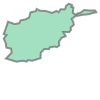

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Получаем координаты требуемого полигона
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
afghanistan = world.loc[world['name'] == 'Afghanistan']
afg_poly = afghanistan['geometry'].iloc[0]
afg_poly

In [2]:
import random
from shapely.geometry import LineString
from math import pi

def distance(angle):
    return pi * 6371 * 1000 * angle / 180

# Общая идея:
# 1. Генерируем случайную точку. Считаем ее базовой.
# 2. Генерируем случайное изменение по Lon, Lat от базовой точки, в пределах расстояния от полигона.
# 3. Если дистанция сокращается, то делаем ее базовой.
# 4. Повторяем поиск, пока проверка по попадание в полигон не будет положительной.

random.seed(12)

X = random.uniform(-180, 180)
Y = random.uniform(-90, 90)
base = Point(X, Y);
points = [(True, base)]
path = [base]

while not base.within(afg_poly):
    b_dist = distance(afg_poly.boundary.distance(base))
    delta = max(0.2, b_dist * 180 * 0.5 / (pi * 6371 * 1000))
    X = random.uniform(-delta, delta)
    Y = random.uniform(-delta, delta)
    new = Point(base.x + X, base.y + Y)
    n_dist = distance(afg_poly.boundary.distance(new))
    if n_dist < b_dist:
        base = new
        points.append((True, new))
        path.append(new)
    else:
        points.append((False, new))

path = LineString(path)
print(f"Total {len(points)} points")

Total 68 points


Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [3]:
import folium

m = folium.Map(location=[10, 20], tiles='cartodbpositron', zoom_start = 3)

folium.GeoJson(afg_poly).add_to(m)
folium.GeoJson(path,
    style_function=lambda feature: { 'color': 'black', 'weight': 1, 'dashArray': '5, 3' },).add_to(m)

for i, p in enumerate(points):
    if not p[0]:
        color = "beige" # ошибочная точка
    elif i == 0:
        color = "green" # начальная точка
    elif i == len(points) - 1:
        color = "red"   # финиш
    else:
        color = "blue"  # промежуточная точка
    
    folium.Marker(location=[p[1].y, p[1].x], popup=f'#{i + 1}', icon=folium.Icon(color)).add_to(m)
    
m

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [4]:
#
# Сформируем список стран, отберем из них те, чьи id заканчиваются на 0
#
import requests
import json
import time
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json][timeout:60];
(
  relation["admin_level"="2"](if:id() >= 2400000000);
  area["admin_level"="2"](if:id() >= 2400000000);
);

out;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
countries = [(x['id'], x['tags']['name'])  for x in response.json()['elements'] 
             if x['id'] % 10 == 0 and 'type' in x['tags'].keys() and x['tags']['type'] == 'boundary']

In [5]:
%%time
#
# С учетом ограничений API на 1 запрос в 30 секунд, получим количество жилой
# недвижимости в странах, занесем в список
#
buildins = []
for c in countries:
    overpass_query = f"""
[out:json][timeout:90];
area({c[0]});
( node(area)[building~"^(apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|terrace)"];
  rel(area)[building~"^(apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|terrace)"];
);
out count;
"""
    response = requests.get(overpass_url, 
                        params={'data': overpass_query})
    buildins.append((c, (response.json()["elements"][0]["tags"]["total"])))
    time.sleep(30)

CPU times: user 76.4 ms, sys: 7.54 ms, total: 84 ms
Wall time: 17min 41s


In [6]:
#
# Страна, с наибольшим количеством зданий, промаркированных как жилые
#
max_b = max(buildins, key=lambda p: int(p[1]))
max_b

((3600195290, 'Malawi'), '9724')

In [7]:
#
# Запрос всех банкоматов, в выбранной стране
#
overpass_query = f"""
[out:json][timeout:300];
area({max_b[0][0]}) -> .a;
(
  node(area.a)[amenity=atm];
);
out geom;
(
  node(area.a)[atm=yes];
);
out geom;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
atm = response.json()

In [8]:
#
# Строим R-Tree. Добавляем координаты банкоматов
#
import rtree.index

atms = {}
idx = rtree.index.Rtree()
for x in atm["elements"]:
    idx.insert(x["id"], Point(x["lon"], x["lat"]).bounds)
    atms.update({x["id"]: Point(x["lon"], x["lat"])})

In [9]:
#
# Получаем коды 5-ти ближайших, к нашей точке в Афганистане, банкоматов
#
atm_list = []
for x in list(idx.nearest(base.bounds, 5)):
    atm_list.append((atms[x].x, atms[x].y))
    print(f"id={x}, ({atms[x].x}, {atms[x].y})")

id=5464908422, (33.775929, -9.5924951)
id=4523230864, (33.9266084, -9.9381732)
id=3674593254, (33.9264695, -9.9381543)
id=4761856205, (33.8560683, -11.022689)
id=4223578610, (33.8560264, -11.0227522)


In [10]:
%%time
#
# Формируем список столиц для списка стран
#
pharmaces = []
for c in countries:
    overpass_query = f"""
[out:json][timeout:90];
area({c[0]});
(
  node[capital=yes](area);
  rel[capital=yes](area);
) -> .a;
.a is_in ->.b;
.b out;
"""
    response = requests.get(overpass_url, params={'data': overpass_query})
    time.sleep(60)

    c_id = 0
    c_level = 100
    for cc in response.json()['elements']:
        if "admin_level" in cc["tags"]:
            level = float(cc["tags"]["admin_level"])
            if level > 2 and level < c_level:
                c_level = level
                c_id = cc["id"]
    
    if c_id > 0:
        overpass_query = f"""
[out:json][timeout:90];
area({c_id});
(
  node(area)[amenity=pharmacy];
);
out count;
"""
    response = requests.get(overpass_url, params={'data': overpass_query})
    if len(response.json()["elements"]) > 0:
        pharmaces.append((c, response.json()["elements"][0]["tags"]["total"]))
        time.sleep(30)

CPU times: user 153 ms, sys: 29.4 ms, total: 182 ms
Wall time: 45min 8s


In [11]:
#
# Выбор страны с максимальным количеством аптек
#
max_p = max(pharmaces, key=lambda p: int(p[1]))
max_p

((3602850940, 'Philippines maritime boundary'), '2280')

In [12]:
#
# Запрос всех школ, в выбранной стране
#
overpass_query = f"""
[out:json][timeout:300];
area({max_p[0][0]});
(
  node(area)[amenity=school];
  rel(area)[amenity=school];
);
out geom;
(
  node(area)[building=school];
  rel(area)[building=school];
);
out geom;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
time.sleep(30)

In [13]:
#
# Строим R-Tree. Добавляем координаты школ
#
schools = {}
idx = rtree.index.Rtree()
for x in response.json()["elements"]:
    idx.insert(x["id"], Point(x["lon"], x["lat"]).bounds)
    schools.update({x["id"]: Point(x["lon"], x["lat"])})

#
# Получаем коды 5-ти ближайших, к нашей точке в Афганистане, школ
#
school_list = []
for x in list(idx.nearest(base.bounds, 5)):
    school_list.append((schools[x].x, schools[x].y))
    print(f"id={x}, ({schools[x].x}, {schools[x].y})")

id=7563318054, (119.8114657, 16.3537213)
id=7563318053, (119.8119915, 16.3538796)
id=7046148114, (117.0209531, 8.1196374)
id=7046103368, (117.0851786, 8.2215001)
id=7046169987, (116.9827195, 7.9565411)


In [14]:
%%time
#
# Для каждой страны:
# 1. Получаем все точки в стране, находим среднее значение lattilude, но это приводит к ошибке:
#    Query ran out of memory in "area-query". Поэтому запрашиваем только жд станции, автобусные остановки
#    и находим географическую середину
# 2. Фильтруем из точек все жд станции и автобусные остановки, считаем соотношение
#
transport = []
i = 0
while i < len(countries):
    c = countries[i]
    overpass_query = f"""
[out:json][timeout:600];
area({c[0]}) -> .a;
(
  node(area.a)[building~'.'];
) -> .h;
.h out geom;
(
  node(area.a)[highway=bus_stop];
) -> .b;
.b out geom;
(
  node(area.a)[railway=station];
) -> .s;
.s out geom;"""
    response = requests.get(overpass_url, params={'data': overpass_query})
    i += 1    
    if "rate_limited" in response.text:
        print("Timeout")
        time.sleep(300)
        i -= 1
    elif len(response.json()["elements"]):
        lat = [float(x["lat"]) for x in response.json()["elements"]]
        lat = (max(lat) + min(lat)) / 2
        bus_stop = [x for x in response.json()["elements"] 
            if "lat" in x and float(x["lat"]) < lat and 
                "tags" in x and "highway" in x["tags"] and x["tags"]["highway"] in ("bus_stop", "platform")]
        station = [x for x in response.json()["elements"] 
            if "lat" in x and float(x["lat"]) < lat and 
                "tags" in x and "railway" in x["tags"] and x["tags"]["railway"] == "station" and
                  ("train" in x["tags"] or "subway" not in x["tags"])]
        coef = 0;
        if len(bus_stop) > 0:
            coef = len(station) / len(bus_stop)
            transport.append((c, coef))
        print(f"{c[1]}, {lat:.2f}°, {coef * 100:.2f}")
        time.sleep(60)

Monaco, 43.74°, 1.85
Brasil, -14.34°, 1.08
Eesti, 58.60°, 0.23
Australia, -26.68°, 3.04
eSwatini, -26.56°, 0.00
বাংলাদেশ, 23.58°, 24.19
سوريا, 34.78°, 74.29
Liberia, 6.74°, 0.00
Ködörösêse tî Bêafrîka - République Centrafricaine, 5.77°, 0.00
ኢትዮጵያ, 8.93°, 5.95
Cameroun, 7.17°, 63.64
Tanzania, -6.20°, 9.04
Malawi, -13.39°, 50.75
Oʻzbekiston, 41.16°, 34.71
Honduras, 14.86°, 0.00
Portugal, 37.34°, 0.36
Azərbaycan, 40.13°, 22.86
臺灣, 23.49°, 0.91
Comores Komori جزر القمر, -11.83°, 0.00
São Tomé e Príncipe, 0.32°, 0.00
Singapore, 1.35°, 0.85
Antigua and Barbuda, 17.10°, 0.00
Kosova / Kosovo, 42.63°, 6.83
Brunei, 4.81°, 0.00
Philippines maritime boundary, 12.49°, 0.25
Norge, 68.12°, 0.29
CPU times: user 4min 39s, sys: 613 ms, total: 4min 39s
Wall time: 41min 53s


In [15]:
#
# Выбор страны с максимальным соотношением жд станций к остановкам
#
max_p = max(transport, key=lambda p: float(p[1]))
max_p

((3600184840, 'سوريا'), 0.7428571428571429)

In [16]:
#
# Запрос всех кинотеатров, в выбранной стране
#
overpass_query = f"""
[out:json][timeout:1200];
area({max_p[0][0]});
(
  node(area)[amenity=cinema];
  rel(area)[amenity=cinema];
);
out geom;
(
  node(area)[building=cinema];
  rel(area)[building=cinema];
);
out geom;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
time.sleep(30)

In [17]:
#
# Строим R-Tree. Добавляем координаты кинотеатров
#
cimenas = {}
idx = rtree.index.Rtree()
for x in response.json()["elements"]:
    idx.insert(x["id"], Point(x["lon"], x["lat"]).bounds)
    cimenas.update({x["id"]: Point(x["lon"], x["lat"])})

#
# Получаем коды 5-ти ближайших, к нашей точке в Афганистане, школ
#
cinema_list = []
for x in list(idx.nearest(base.bounds, 5)):
    cinema_list.append((cimenas[x].x, cimenas[x].y))
    print(f"id={x}, ({cimenas[x].x}, {cimenas[x].y})")

id=7811088385, (41.2173437, 37.0479362)
id=7811088086, (41.2158978, 37.0456554)
id=3639497459, (37.1556957, 36.2113753)
id=6682123385, (37.1501132, 36.2064002)
id=6694632786, (37.1500833, 36.206388)


In [18]:
#
# Визуализируем получившееся
#
lon = (base.y + atm_list[0][1] + school_list[0][1] + cinema_list[0][1]) / 4
lat = (base.x + atm_list[0][0] + school_list[0][0] + cinema_list[0][0]) / 4

m = folium.Map(location=[lon, lat], tiles='cartodbpositron', zoom_start = 3)

folium.Marker(location=[base.y, base.x], popup='<b>ATM</b>', icon=folium.Icon("blue")).add_to(m)

for p in atm_list:
    folium.Marker(location=[p[1], p[0]], popup='<b>ATM</b>', icon=folium.Icon("red")).add_to(m)
    folium.GeoJson(
        LineString((base, Point(p[0], p[1]))),
        style_function=lambda feature: { 'color': 'black', 'weight': 0.5, 'dashArray': '4, 3' },
    ).add_to(m)

for p in school_list:
    folium.Marker(location=[p[1], p[0]], popup='<b>School</b>', icon=folium.Icon("green")).add_to(m)
    folium.GeoJson(
        LineString((base, Point(p[0], p[1]))),
        style_function=lambda feature: { 'color': 'black', 'weight': 0.5, 'dashArray': '4, 3' },
    ).add_to(m)

for p in cinema_list:
    folium.Marker(location=[p[1], p[0]], popup='<b>Cinema</b>', icon=folium.Icon("beige")).add_to(m)
    folium.GeoJson(
        LineString((base, Point(p[0], p[1]))),
        style_function=lambda feature: { 'color': 'black', 'weight': 0.5, 'dashArray': '4, 3' },
    ).add_to(m)
    
m

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [19]:
import requests
import json
from openrouteservice import client
from shapely import geometry
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import folium

#
# Скачиваем и обрабатываем данные о расположении школ
#
school_json = requests.get("https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.json?accessType=DOWNLOAD").json()
school_points = [tuple(map(float, x[8].replace("POINT (","").replace(")", "").split())) for x in school_json["data"]]

In [20]:
api_key = '5b3ce3597851110001cf62480653249964134494af7abbaeaf123fae'
clnt = client.Client(key=api_key)

def style_function(color, opacity=0.5):
    return lambda feature: dict(color=color, weight=3, opacity=opacity)

# Центрируем нашу карту
m = folium.Map(location=[40.732, -73.97], tiles='cartodbpositron',zoom_start = 12)

# Начальная и конечная точки
start = Point(-73.9730173, 40.7644481);
finish = Point(-73.98958, 40.70320);

folium.Marker(location=[start.y, start.x], popup=f'Start', icon=folium.Icon("green")).add_to(m)
folium.Marker(location=[finish.y, finish.x], popup=f'Finish', icon=folium.Icon("red")).add_to(m)

request_params = {'coordinates': [[start.x, start.y],
                                 [finish.x, finish.y]],
                'format_out': 'geojson',
                'profile': 'driving-car',
                'preference': 'shortest',
                'instructions': 'false',}

# Строим и отображаем прямой путь, без учетов препятствий
route_normal = clnt.directions(**request_params)
folium.features.GeoJson(data=route_normal,
                        name='Route with school',
                        style_function=style_function('#FF0000'),
                        overlay=True).add_to(m)

# Отображаем школы на пути следования
route_buffer = LineString(route_normal['features'][0]['geometry']['coordinates']).buffer(0.001)
school_poly = []
for school_point in school_points:
    poly = Polygon([
        (school_point[0] - 0.0012, school_point[1] - 0.0008),
        (school_point[0] - 0.0012, school_point[1] + 0.0008),
        (school_point[0] + 0.0012, school_point[1] + 0.0008),
        (school_point[0] + 0.0012, school_point[1] - 0.0008)])
    school_poly.append(poly)
    if route_buffer.intersects(poly):
        folium.features.Marker(list(reversed(poly.centroid.coords[0]))).add_to(m)
        folium.GeoJson(Point(poly.centroid.coords[0]).buffer(0.0008),
            style_function=style_function('#FF8080', 0.1)).add_to(m)
        
# Строим маршрут без препятствий
request_params['options'] = {'avoid_polygons': geometry.mapping(MultiPolygon(school_poly))}
route_detour = clnt.directions(**request_params)

route2_buffer = LineString(route_detour['features'][0]['geometry']['coordinates']).buffer(0.0002)
route2_buffer2 = LineString(route_detour['features'][0]['geometry']['coordinates']).buffer(0.003)
folium.features.GeoJson(data=geometry.mapping(route2_buffer),
                        name='Route Buffer',
                        style_function=style_function('#80FF80', 0.1),
                        overlay=True).add_to(m)

folium.features.GeoJson(data=route_detour,
                        name='Route without school',
                        style_function=style_function('#00FF00'),
                        overlay=True).add_to(m)


for poly in school_poly:
    if route2_buffer2.intersects(poly):
        folium.features.Marker(list(reversed(poly.centroid.coords[0]))).add_to(m)
        folium.GeoJson(Point(poly.centroid.coords[0]).buffer(0.0008),
                       style_function=style_function('#FF8080', 0.1)).add_to(m)

m

In [21]:
import datetime
print(datetime.datetime.now())

2020-10-30 23:35:18.981120
